In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages

In [2]:
# basic
import numpy as np
import pandas as pd

In [3]:
# graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 18.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
# forecasting
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pmdarima as pm

In [6]:
# 3d plot
from mpl_toolkits.mplot3d import Axes3D

# Data Loading

##Data Files

In [7]:
# import data
dt = pd.read_excel('/content/drive/MyDrive/Seminar QML/dataset.xlsx')
# dt.columns = ['x', 'y']

In [8]:
relevance = pd.read_excel('/content/drive/MyDrive/Seminar QML/EUR_BusinessCase_Chunk_RelevanceScore_V2.xlsx')
sizegroup = pd.read_excel('/content/drive/MyDrive/Seminar QML/EUR_BusinessCase_Sizegroup_Costs.xlsx')

In [9]:
products = dt.chunkname.drop_duplicates().tolist()

In [10]:
conditions = [dt.year==2018, dt.year==2019, dt.year==2020]
values = [dt.week, dt.week+52, dt.week+104]

dt['weekyear'] = np.select(conditions, values)

In [ ]:
sizes = ['3XS', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL']
G = ['General Toys', 'Recreational and Outdoor Toys']
for g in G:
  for i in products:
    for s in sizes:
      df = dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]
      med_m3 = df['averagem3'].median() #can be changed later
      med_price = df['averageprice'].median() #can be changed later
      df['averagem3'] = df['averagem3'].fillna(med_m3)
      df['averageprice'] = df['averageprice'].fillna(med_m3)
      mean_m3 = df['averagem3'].mean()
      mean_price = df['averageprice'].mean()
      std_m3 = df['averagem3'].std()
      std_price = df['averageprice'].std()
      outlier_m3 = df[(df['averagem3'] - mean_m3).abs() > 3.5*std_m3]
      outlier_price = df[(df['averageprice'] - mean_price).abs() > 3.5*std_price]
      dt.loc[outlier_m3.index, 'averagem3'] = med_m3
      dt.loc[outlier_price.index, 'averageprice'] = med_price
      # nan_rows = df[]
      # dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]['averagem3'] = dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]['averagem3'].fillna(med_m3)
      # dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]['averageprice'] = dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]['averageprice'].fillna(med_price)
      if (not df.empty) & df.shape[0] < 105:
        weeks = list(set(range(1, 106)) - set(df.weekyear))
        weekdt = pd.DataFrame({'weekyear': weeks})
        weekdt['SHop'] = 'Toys'
        weekdt['productGroup'] = g
        weekdt['chunkname'] = i
        weekdt['sizegroup'] = s
        weekdt['averagem3'] = mean_m3
        weekdt['averageprice'] = mean_price
        weekdt['qtysales'] = 0
        weekdt['week'] = weekdt.weekyear%52
        weekdt['year'] = weekdt.weekyear//52 + 2018
        # for w in range(106):
        #   if w not in df.weekyear:
        #     thisweek = week.copy()
        #     thisweek.update({'week': w%52, 'year': w//52 + 2018, 'weekyear': w})
        #     # dt.append(week, ignore_index=True)
        dt = pd.concat([dt, weekdt], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
count = 0
for g in G:
  for i in products:
    for s in sizes:
      df = dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]
      if df.shape[0] < 105:
        count+=1

count

In [ ]:
dt = dt.dropna()

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186269 entries, 0 to 944579
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          186269 non-null  float64
 1   week          186269 non-null  float64
 2   qtysales      186269 non-null  int64  
 3   productGroup  186269 non-null  object 
 4   SHop          186269 non-null  object 
 5   chunkname     186269 non-null  object 
 6   sizegroup     186269 non-null  object 
 7   averagem3     186269 non-null  float64
 8   averageprice  186269 non-null  float64
 9   weekyear      186269 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 15.6+ MB


In [ ]:
df = dt[(dt.productGroup == 'Recreational and Outdoor Toys')&(dt.chunkname == 'Modelspoorwagon')&(dt.sizegroup == 'XXS')]
med_price = df['averageprice'].median() #can be changed later
dt['averageprice'] = dt['averageprice'].fillna(med_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dt[dt.averagem3.isna()]

,year,week,qtysales,productGroup,SHop,chunkname,sizegroup,averagem3,averageprice,weekyear


In [ ]:
dt['dummy.45'] = np.where(dt.week==45, 1, 0)
dt['dummy.46'] = np.where(dt.week==46, 1, 0)
dt['dummy.47'] = np.where(dt.week==47, 1, 0)
dt['dummy.48'] = np.where(dt.week==48, 1, 0)
dt['dummy.49'] = np.where(dt.week==49, 1, 0)
dt['dummy.50'] = np.where(dt.week==50, 1, 0)
dt['dummy.51'] = np.where(dt.week==51, 1, 0)

In [ ]:
dt['dummy'] = np.where((dt.week>=45)&(dt.week<=51), 1, 0)

##Solution Files

In [14]:
def solution_handling(solution):
  solution = solution.iloc[1:].T
  solution = solution.replace('XXXS', '3XS')
  solution = solution.replace('XXXL', '3XL')
  columns = ['Product', 'Size', 'y']
  columns.extend(list(range(1, 53)))
  solution.columns = columns
  solution = solution.dropna()
  return solution

In [15]:
sol = pd.read_excel('/content/drive/MyDrive/Seminar QML/Solution_W1.xlsx', header = None)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [16]:
sol = solution_handling(sol)

In [17]:
category = sol.iloc[:2].T.drop_duplicates()
category.columns = ['Category', 'Product']

gen = category[category.Category == 'General Toys'].Product.tolist()
rec = category[category.Category == 'Recreational and Outdoor Toys'].Product.tolist()

# Data Analysis

In [ ]:
dt_peak = dt[dt.dummy==1]

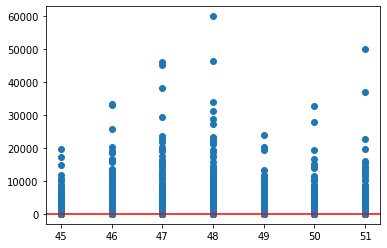

In [ ]:
plt.scatter(dt_peak.week, dt_peak.qtysales)
plt.axhline(y=5,color='r')
plt.show()

# Graph 2018

In [11]:
def sum_stats(solution, df):
  weeks = {}
  sum_stat = {}

  for i in range(1, 53):
    solweek = solution[['Product', 'Size', 'y', i]]
    # print(solweek)
    dtweek = df[df.week == i][['productGroup', 'chunkname', 'sizegroup', 'qtysales', 'averageprice', 'averagem3']]
    dtweek['Product'] = dtweek.chunkname + '_' + dtweek.productGroup
    # print(dtweek)
    dtweek = dtweek.drop(labels=['chunkname'], axis=1)
    dtweek.columns = ['productGroup', 'Size', 'qtysales', 'averageprice', 'averagem3', 'Product']
    week = pd.merge(solweek, dtweek, on = ['Product', 'Size'])
    # print(dtweek)
    # handling 0 sales with 2 methods
    # either replace 0 with inf as follows
    # week = week['qtysales'].replace([0], np.inf)
    # or directly removes them
    week = week[week.qtysales != 0]
    week['ServiceLevel'] = week[i]/week['qtysales']
    week['Revenue'] = week[i]*week['averageprice']
    week['Volume'] = week[i]*week['averagem3']
    # week.to_excel(str(i) + '.xlsx')
    warehouse = week.groupby('y').sum()
    # print(warehouse)
    sum_stat[i] = week.Size.value_counts().to_dict()
    sum_stat[i].update({'Total Revenue': week.Revenue.sum(),
                        'Total Volume': week.Volume.sum(),
                        'Volume Small': warehouse.loc[0, 'Volume'] if 0 in warehouse.index else 0,
                        'Volume Big': warehouse.loc[1, 'Volume'] if 1 in warehouse.index else 0})
    weeks[i] = week
    week = week.drop(labels=['Product', 'Size', 'y', 'averageprice', 'averagem3', 'Revenue', 'Volume'], axis=1)
    week = week.groupby('productGroup').mean()
    # print(week.loc['General Toys',i])
    # print(week.loc['General Toys','qtysales'])
    sum_stat[i].update({'Average Service Level (General Toys)': week.loc['General Toys','ServiceLevel'],
                        # week.loc['General Toys',i]/week.loc['General Toys','qtysales'],
                        'Average Service Level (Recreational and Outdoor Toys)':  week.loc['Recreational and Outdoor Toys','ServiceLevel']})
                        # week.loc['Recreational and Outdoor Toys',i]/week.loc['Recreational and Outdoor Toys','qtysales']})
  sum_stats = pd.DataFrame(sum_stat).T
  return weeks, sum_stats

In [18]:
weeks, sum_stat = sum_stats(sol, dt[dt.year==2018])

In [ ]:
def projecting(solution, df):
  weeks = {}
  sum_stat = {}

  for i in range(1, 53):
    solweek = solution[['Product', 'Size', 'y', i]]
    dtweek = df[df.week == i][['productGroup', 'chunkname', 'sizegroup', 'qtysales', 'averageprice', 'averagem3']]
    dtweek['Product'] = dtweek.chunkname + '_' + dtweek.productGroup
    dtweek = dtweek.drop(labels=['chunkname'], axis=1)
    dtweek.columns = ['productGroup', 'Size', 'qtysales', 'averageprice', 'averagem3', 'Product']
    week = pd.merge(solweek, dtweek, on = ['Product', 'Size'])
    week['Sale'] = week[[i, 'qtysales']].min(axis=1)
    # handling 0 sales with 2 methods
    # either replace 0 with inf as follows
    # week = week['qtysales'].replace([0], np.inf)
    # or directly removes them
    week = week[week.qtysales != 0]
    week['ServiceLevel'] = week['Sale']/week['qtysales']
    week['Revenue'] = week['Sale']*week['averageprice']
    week['Volume'] = week['Sale']*week['averagem3']
    # week['Volume Small'] = week.groupby('y').sum().loc(0, 'Volume')
    # week['Volume Big'] = week.groupby('y').sum().loc(1, 'Volume')
    warehouse = week.groupby('y').sum()
    sum_stat[i] = week.Size.value_counts().to_dict()
    sum_stat[i].update({'Total Revenue': week.Revenue.sum(),
                        'Total Volume': week.Volume.sum(),
                        'Volume Small': warehouse.loc[0, 'Volume'],
                        'Volume Big': warehouse.loc[1, 'Volume']})
    weeks[i] = week
    week = week.drop(labels=['Product', 'Size', 'y', 'qtysales', 'averageprice', 'averagem3', 'Revenue', 'Volume', 'Sale', i], axis=1)
    week = week.groupby('productGroup').mean()
    sum_stat[i].update({'Average Service Level (General Toys)': week.loc['General Toys','ServiceLevel'],
                        'Average Service Level (Recreational and Outdoor Toys)': week.loc['Recreational and Outdoor Toys','ServiceLevel']})
  sum_stats = pd.DataFrame(sum_stat).T
  return weeks, sum_stats

In [ ]:
weeks_2019, sum_stats_2019 = projecting(sol, dt[dt.year == 2019])

In [ ]:
# plt.subplot(1, 2, 1)
def plot_average_service_level(sum_stats, save, show):
  plt.plot(sum_stats.index, sum_stats['Average Service Level (General Toys)'], label = 'General Toys')
  plt.plot(sum_stats.index, sum_stats['Average Service Level (Recreational and Outdoor Toys)'], label = 'Recreational and Outdoor Toys')
  plt.xlabel('Week')
  plt.ylabel('Average Service Level')
  plt.legend()
  if save:
    plt.savefig('fig1.png')
  if show:
    plt.show()

In [ ]:
def plot_revenue(sum_stats, num, label):
  plt.plot(sum_stats.index, sum_stats['Total Revenue'], label = label)
  plt.xlabel('Week')
  plt.ylabel('Euro')
  plt.savefig('fig'+num+'.png')
  plt.show()

In [ ]:
plt.plot(sum_stat.index, sum_stat['Total Revenue'], label = '2018')
plt.plot(sum_stats_2019.index, sum_stats_2019['Total Revenue'], label = '2019')
plt.xlabel('Week')
plt.ylabel('Euro')
plt.legend()

plt.savefig('fig2.png')

plt.show()

NameError: ignored

In [23]:
def plot_capacity(sum_stats, num):
  plt.plot(sum_stats.index, sum_stats['Total Volume'])
  plt.xlabel('Week')
  plt.ylabel('M3')
  plt.savefig('fig'+num+'.png')
  plt.show()

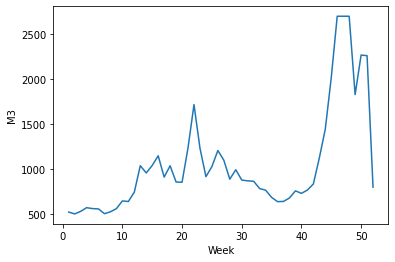

In [26]:
plt.plot(sum_stat.index, sum_stat['Total Volume'], label = '2018')
# plt.plot(sum_stats_2019.index, sum_stats_2019['Total Volume'], label = '2019')
plt.xlabel('Week')
plt.ylabel('M3')
# plt.legend()

plt.savefig('fig3.png')

plt.show()

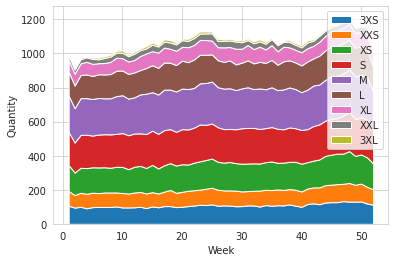

In [ ]:
sns.set_style("whitegrid")

plt.stackplot(sum_stats.index, sum_stats['3XS'], sum_stats['XXS'], sum_stats['XS'], sum_stats['S'], sum_stats['M'], sum_stats['L'], sum_stats['XL'], sum_stats['XXL'], sum_stats['3XL'],
              labels = ['3XS', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL'])
              # , colors=['darkorange', 'orange', 'moccasin', 'cornsilk', 'gold', 'goldenrod', 'darkgoldenrod'])
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.legend()

plt.savefig('fig4.png')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: U

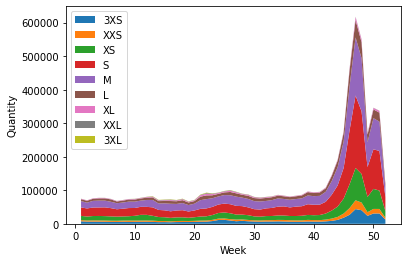

In [22]:
dt2018 = dt[dt.year==2018]

plt.stackplot(sum_stat.index,
              dt2018[dt.sizegroup == '3XS'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'XXS'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'XS'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'S'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'M'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'L'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'XL'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == 'XXL'].groupby('week').sum()['qtysales'],
              dt2018[dt.sizegroup == '3XL'].groupby('week').sum()['qtysales'],
              labels = ['3XS', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL'], linewidth = 0)

plt.xlabel('Week')
plt.ylabel('Quantity')
plt.legend(loc = 'upper left')

plt.savefig('fig5.png')

plt.show()

# Graphing 2019

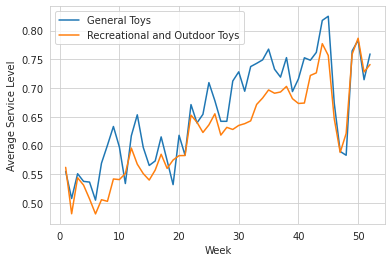

In [ ]:
# plt.subplot(1, 2, 1)
plt.plot(sum_stats_2019.index, sum_stats_2019['Average Service Level (General Toys)'], label = 'General Toys')
plt.plot(sum_stats_2019.index, sum_stats_2019['Average Service Level (Recreational and Outdoor Toys)'], label = 'Recreational and Outdoor Toys')
plt.xlabel('Week')
plt.ylabel('Average Service Level')
plt.legend()

plt.savefig('fig6.png')

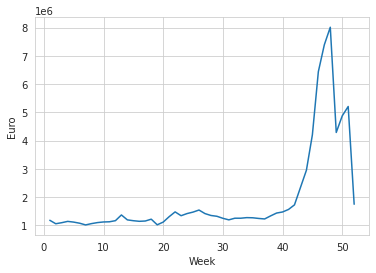

In [ ]:
plt.plot(sum_stats_2019.index, sum_stats_2019['Total Revenue'], label = 'Total Revenue')
plt.xlabel('Week')
plt.ylabel('Euro')
# plt.legend()

plt.savefig('fig7.png')

plt.show()

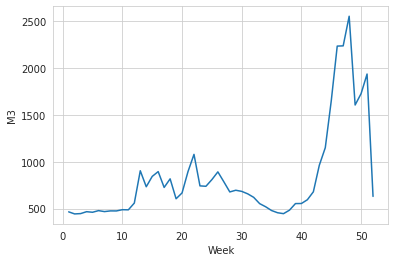

In [ ]:
plt.plot(sum_stats_2019.index, sum_stats_2019['Total Volume'], label = 'Total Volume')
plt.xlabel('Week')
plt.ylabel('M3')
# plt.legend()

plt.savefig('fig8.png')

plt.show()

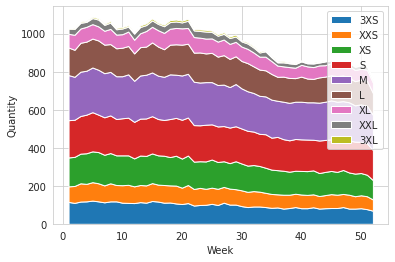

In [ ]:
sns.set_style("whitegrid")

plt.stackplot(sum_stats_2019.index, sum_stats_2019['3XS'], sum_stats_2019['XXS'], sum_stats_2019['XS'], sum_stats_2019['S'], sum_stats_2019['M'], sum_stats_2019['L'], sum_stats_2019['XL'], sum_stats_2019['XXL'], sum_stats_2019['3XL'],
              labels = ['3XS', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL'])
              # , colors=['darkorange', 'orange', 'moccasin', 'cornsilk', 'gold', 'goldenrod', 'darkgoldenrod'])
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.legend()

plt.savefig('fig9.png')

plt.show()

# Graphing - Trade-off

In [ ]:
ca = pd.read_excel('/content/drive/MyDrive/Seminar QML/Capacity Analysis.xlsx')

ca.head()

,Capacity percentage,revenue
0,0.126,20683379
1,0.127,20932990
2,0.128,21108807
3,0.129,21257619
4,0.130,21390258


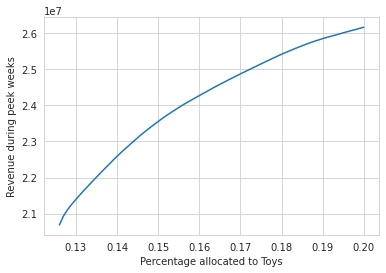

In [ ]:
plt.plot(ca['Capacity percentage'], ca['revenue'], label = 'Total Revenue')
plt.xlabel('Percentage allocated to Toys')
plt.ylabel('Revenue during peek weeks')
# plt.legend()

plt.savefig('fig10.png')

plt.show()

In [ ]:
rr = pd.read_excel('/content/drive/MyDrive/Seminar QML/Relevance - Revenue.xlsx')

rr.head()

,Minimum relevance level,Revenue
0,0.910,23555738
1,0.911,23555738
2,0.912,23555738
3,0.913,23555738
4,0.914,23555738


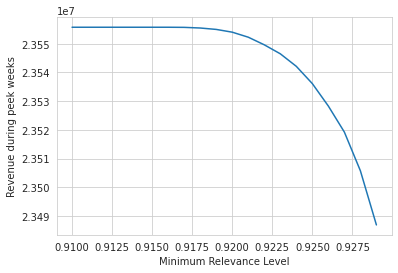

In [ ]:
plt.plot(rr['Minimum relevance level'], rr['Revenue'], label = 'Total Revenue')
plt.xlabel('Minimum Relevance Level')
plt.ylabel('Revenue during peek weeks')
# plt.legend()

plt.savefig('fig11.png')

plt.show()

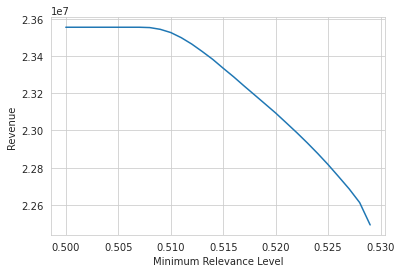

In [ ]:
rr2 = pd.read_excel('/content/drive/MyDrive/Seminar QML/Relevance - Revenue 2.xlsx')

plt.plot(rr2['minimum relevance level'], rr2['Revenue'], label = 'Total Revenue')
plt.xlabel('Minimum Relevance Level')
plt.ylabel('Revenue')
# plt.legend()

plt.savefig('fig12.png')

plt.show()

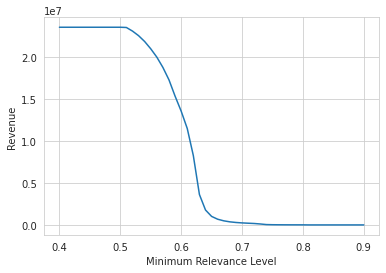

In [ ]:
rr3 = pd.read_excel('/content/drive/MyDrive/Seminar QML/Relevance - Revenue 3.xlsx')

plt.plot(rr3['minimum relevance level'], rr3['Revenue'], label = 'Total Revenue')
plt.xlabel('Minimum Relevance Level')
plt.ylabel('Revenue')
# plt.legend()

plt.savefig('fig13.png')

plt.show()

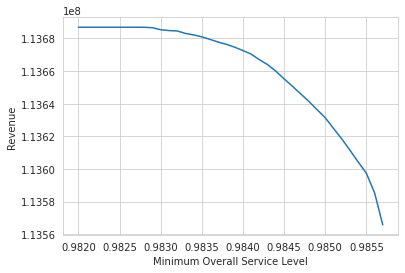

In [ ]:
sr = pd.read_excel('/content/drive/MyDrive/Seminar QML/Service - Revenue.xlsx')

plt.plot(sr['Overall service level'], sr['Revenue'], label = 'Total Revenue')
plt.xlabel('Minimum Overall Service Level')
plt.ylabel('Revenue')
# plt.legend()

plt.savefig('fig14.png')

plt.show()

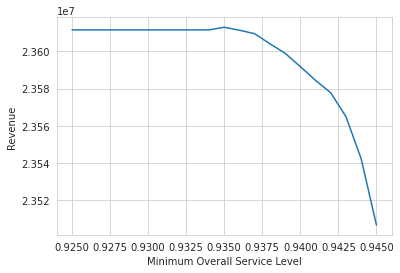

In [ ]:
sr2 = pd.read_excel('/content/drive/MyDrive/Seminar QML/Service - Revenue 2.xlsx')

plt.plot(sr2['Service level'], sr2['Renvenue'], label = 'Total Revenue')
plt.xlabel('Minimum Overall Service Level')
plt.ylabel('Revenue')
# plt.legend()

plt.savefig('fig15.png')

plt.show()

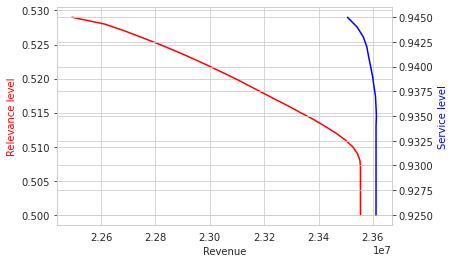

In [ ]:
fig,ax = plt.subplots()
ax.plot(rr2['Revenue'], rr2['minimum relevance level'], label = 'Relevance Level', color="red")
ax.set_xlabel('Revenue')
ax.set_ylabel('Relevance level',color="red")
ax2=ax.twinx()
ax2.plot(sr2['Renvenue'], sr2['Service level'], color="blue")
ax2.set_ylabel('Service level',color="blue")
plt.show()

In [ ]:
sns.relplot(data=dt[dt['chunkname'] == 'Knuffel'][dt['year']!=2020], x='week', y='averageprice', hue='year', kind='line')

# Trials

In [ ]:
# sns.jointplot(data=dt[dt.year!=2020], x='averageprice', y='averagem3', hue='year', kind='kde')

# plt.savefig('fig12.png')

In [ ]:
# dt[dt.averageprice>800]

In [ ]:
# dt[dt.averagem3>0.8]

In [ ]:
dt2018_sample = dt[(dt.year==2018)&(dt.chunkname=='RC voertuigonderdeel')&(dt.sizegroup=='XS')]

In [ ]:
dt2018_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 43 to 105841
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    41 non-null     int64  
 1   year          41 non-null     int64  
 2   week          41 non-null     int64  
 3   qtysales      41 non-null     float64
 4   productGroup  41 non-null     object 
 5   SHop          41 non-null     object 
 6   chunkname     41 non-null     object 
 7   sizegroup     41 non-null     object 
 8   averagem3     41 non-null     float64
 9   averageprice  41 non-null     float64
 10  weekyear      41 non-null     int64  
 11  dummy.45      41 non-null     int64  
 12  dummy.46      41 non-null     int64  
 13  dummy.47      41 non-null     int64  
 14  dummy.48      41 non-null     int64  
 15  dummy.49      41 non-null     int64  
 16  dummy.50      41 non-null     int64  
 17  dummy.51      41 non-null     int64  
 18  dummy         41 non-null  

In [ ]:
m = smf.ols(formula = 'qtysales ~ averageprice + averagem3', data = dt2018_sample).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               qtysales   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     5.368
Date:                Tue, 29 Mar 2022   Prob (F-statistic):            0.00780
Time:                        07:22:13   Log-Likelihood:                -289.89
No. Observations:                  52   AIC:                             585.8
Df Residuals:                      49   BIC:                             591.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      327.8257     77.823      4.212      0.000     171.434     484.217
averageprice    -6.6722      3.600     -1.853      0.070     -13.906       0.562
averagem3      394.4189   2163.318      0.182      0.856   -3952.932    4741.770
==============================================================================
Omnibus:                       41.557   Durbin-Watson:                   0.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.339
Skew:                           2.272   Prob(JB):                     3.68e-28
Kurtosis:                       9.137   Cond. No.                     8.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
dt2018_sample.set_index('week', inplace=True)

In [ ]:
dt2018_sample['dummy'] = np.where(dt2018_sample.index>=45, np.where(dt2018_sample.index<=51, 1, 0), 0)

In [ ]:
dt2018_sample

,year,week,qtysales,productGroup,SHop,chunkname,sizegroup,averagem3,averageprice


<Figure size 432x288 with 0 Axes>

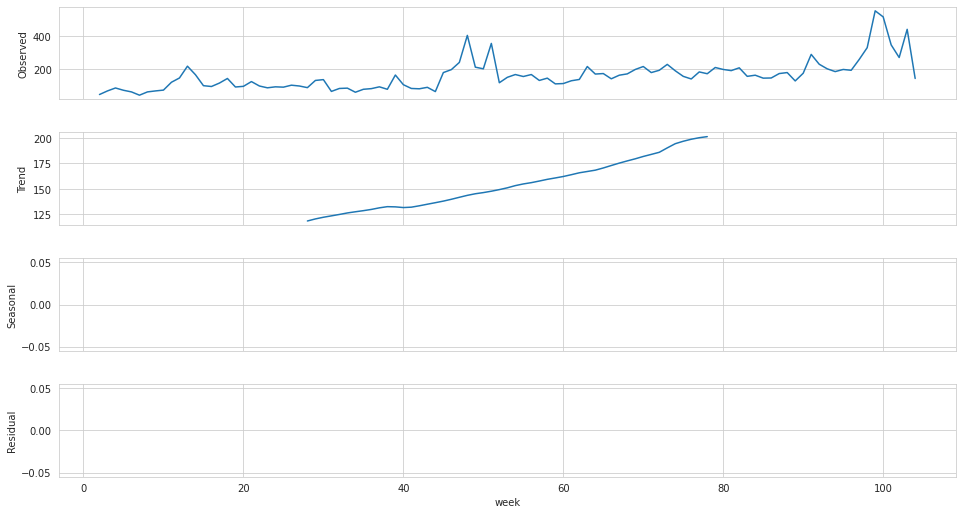

In [ ]:
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(pd.concat([dt2018_sample, dt2019_test]).qtysales, freq=52)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

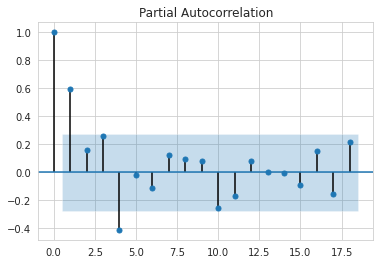

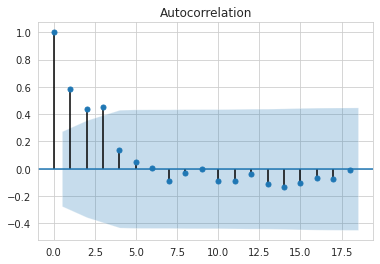

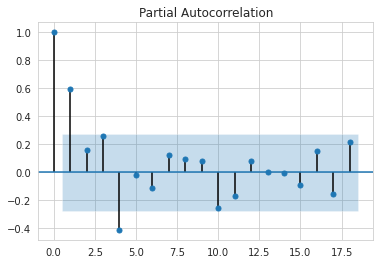

In [ ]:
plot_acf(dt2018_sample.qtysales)
plot_pacf(dt2018_sample.qtysales)

In [ ]:
m = smf.ols(formula = 'qtysales ~ averageprice + averagem3 + prev_qtysales + time', data = dt2018_sample).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               qtysales   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     13.60
Date:                Tue, 29 Mar 2022   Prob (F-statistic):           2.15e-07
Time:                        07:22:13   Log-Likelihood:                -269.51
No. Observations:                  51   AIC:                             549.0
Df Residuals:                      46   BIC:                             558.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       221.0527     63.843      3.462      0.001      92.544     349.561
averageprice    -11.6628      3.117     -3.741      0.001     -17.938      -5.388
averagem3      6903.5088   2462.925      2.803      0.007    1945.897    1.19e+04
prev_qtysales     0.4265      0.118      3.604      0.001       0.188       0.665
time              2.0373      0.852      2.392      0.021       0.323       3.752
==============================================================================
Omnibus:                       18.960   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.017
Skew:                           1.059   Prob(JB):                     1.51e-08
Kurtosis:                       6.530   Cond. No.                     4.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
model = ARIMA(endog=dt2018_sample.qtysales, exog=dt2018_sample[['averageprice', 'averagem3', 'dummy.45', 'dummy.46','dummy.47','dummy.48','dummy.49','dummy.50']], order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ----------


                              ARMA Model Results                              
Dep. Variable:               qtysales   No. Observations:                   52
Model:                     ARMA(1, 1)   Log Likelihood                -262.892
Method:                       css-mle   S.D. of innovations             37.694
Date:                Wed, 30 Mar 2022   AIC                            549.783
Time:                        18:47:05   BIC                            573.198
Sample:                             0   HQIC                           558.760
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            284.2565     57.509      4.943      0.000     171.541     396.972
averageprice      -5.9697      1.970     -3.031      0.004      -9.830      -2.110
averagem3        759.3835   1826.751

In [ ]:
dt2019_test = dt[(dt.year==2019)&(dt.chunkname=='RC voertuigonderdeel')&(dt.sizegroup=='XS')]
# dt2019_test.set_index('week', inplace=True)
# dt2019_test['prev_qtysales'] = dt2019_test['qtysales'].shift(1, axis=0)
# dt2019_test['dummy'] = np.where(dt2019_test.index>=45, np.where(dt2019_test.index<=50, 1,0), 0)
dt2019_test['week'] = dt2019_test.week + 52
dt2019_test.set_index('week', inplace=True)
# dt2019_test.fillna(116)
dt2019_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Unnamed: 0,year,qtysales,productGroup,SHop,chunkname,sizegroup,averagem3,averageprice,weekyear,dummy.45,dummy.46,dummy.47,dummy.48,dummy.49,dummy.50,dummy.51,dummy,LB,UB
week,,,,,,,,,,,,,,,,,,,,
55,5936,2019,1.0,General Toys,Toys,RC voertuigonderdeel,XS,0.0003,16.520000,55,0,0,0,0,0,0,0,0,NaN,NaN
56,8546,2019,4.0,General Toys,Toys,RC voertuigonderdeel,XS,0.0003,11.757500,56,0,0,0,0,0,0,0,0,NaN,NaN
58,10865,2019,3.0,General Toys,Toys,RC voertuigonderdeel,XS,0.0003,11.756667,58,0,0,0,0,0,0,0,0,NaN,NaN
71,39214,2019,2.0,General Toys,Toys,RC voertuigonderdeel,XS,0.0003,4.125000,71,0,0,0,0,0,0,0,0,NaN,NaN


In [ ]:
dt2019_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 55 to 71
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4 non-null      int64  
 1   year          4 non-null      int64  
 2   qtysales      4 non-null      float64
 3   productGroup  4 non-null      object 
 4   SHop          4 non-null      object 
 5   chunkname     4 non-null      object 
 6   sizegroup     4 non-null      object 
 7   averagem3     4 non-null      float64
 8   averageprice  4 non-null      float64
 9   weekyear      4 non-null      int64  
 10  dummy.45      4 non-null      int64  
 11  dummy.46      4 non-null      int64  
 12  dummy.47      4 non-null      int64  
 13  dummy.48      4 non-null      int64  
 14  dummy.49      4 non-null      int64  
 15  dummy.50      4 non-null      int64  
 16  dummy.51      4 non-null      int64  
 17  dummy         4 non-null      int64  
 18  LB            0 non-null      fl

In [ ]:
pred = model_fit.predict(1, 52, dt2019_test[['averageprice', 'averagem3', 'dummy']])
pred.shape

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


(52,)

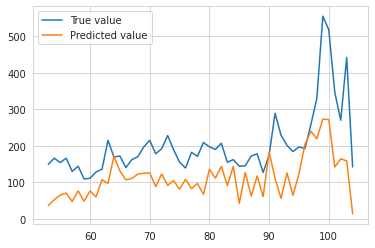

In [ ]:
plt.plot(dt2019_test.index, dt2019_test['qtysales'], label='True value')
plt.plot(dt2019_test.index, pred, label='Predicted value')

plt.legend()

plt.show()

In [ ]:
dt2019_test['qtysales'].index = dt2019_test['qtysales'].index - 52

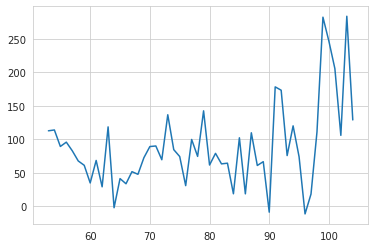

In [ ]:
plt.plot(dt2019_test.index, dt2019_test['qtysales']-pred, label='Residuals')

plt.show()

In [ ]:
np.abs(np.array(dt2019_test['qtysales'])-pred).mean()

89.93387200768595

In [ ]:
model = pm.auto_arima(dt2018_sample.qtysales,
                      X=dt2018_sample[['averageprice', 'averagem3', 'dummy.45', 'dummy.46','dummy.47','dummy.48', 'dummy.49', 'dummy.50', 'dummy.51']],
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      # m=52,
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=347.916, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=351.960, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=346.850, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=345.996, Time=0.36 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=347.927, Time=0.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=349.346, Time=0.46 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=346.905, Time=0.39 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 2.480 seconds


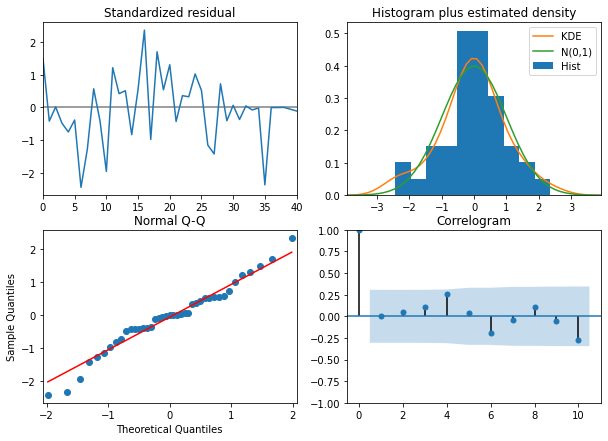

In [ ]:
model.plot_diagnostics(figsize=(10,7))
plt.show()

In [ ]:
fc, conf = model.predict(n_periods=52, X=dt2019_test[['averageprice', 'averagem3', 'dummy.45', 'dummy.46','dummy.47','dummy.48', 'dummy.49', 'dummy.50', 'dummy.51']], return_conf_int=True)

ValueError: ignored

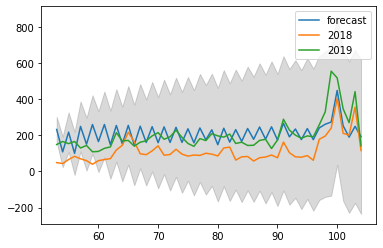

In [ ]:
plt.plot(dt2019_test.index, fc, label='forecast')
plt.plot(dt2019_test.index, dt2018_sample.qtysales, label='2018')
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])
plt.fill_between(dt2019_test.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.plot(dt2019_test.index, dt2019_test['qtysales'], label='2019')
plt.legend()

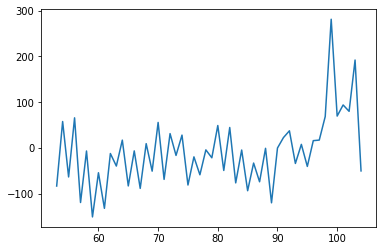

In [ ]:
plt.plot(dt2019_test.index, dt2019_test['qtysales']-fc, label='Residuals')

plt.show()

In [ ]:
np.abs(np.array(dt2019_test['qtysales'])-fc).mean()

57.41736588548638

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -255.801
Date:                Wed, 30 Mar 2022   AIC                            527.602
Time:                        19:19:38   BIC                            543.057
Sample:                             0   HQIC                           533.508
                                 - 52                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
averageprice    -7.1849      1.815     -3.959      0.000     -10.741      -3.628
averagem3     1620.7038   2515.455      0.644      0.519   -3309.497    6550.904
dummy.46        72.0872    138.211      0.522      0.602    -198.802     342.976
dummy.47        17.6095     95.473      0.184      0.854    -169.514     204.733
dummy.48       243.1956     31.018      7.841      0.000     182.402     303.989
ar.L1           -0.9839      0.053    -18.661      0.000      -1.087      -0.881
ma.L1            0.6599      0.186      3.542      0.000       0.295       1.025
sigma2        1278.4993    244.342      5.232      0.000     799.597    1757.401
===================================================================================
Ljung-Box (Q):                       43.35   Jarque-Bera (JB):                26.29
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               2.88   Skew:                            -0.97
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
params = pd.DataFrame(model.params()).T
params['chunkname'] = 'Babygym'
params

,averageprice,averagem3,dummy.46,dummy.47,dummy.48,ar.L1,ma.L1,sigma2,chunkname
0,-7.184858,1620.703839,72.087219,17.609463,243.195646,-0.983942,0.659878,1278.499309,Babygym


In [ ]:
pd.DataFrame(np.arange(1, 52, 1))

RangeIndex(start=0, stop=1, step=1)

In [ ]:
tester = pd.DataFrame(np.arange(1, 53, 1))
tester.columns = ['week']
tester['year'] = 2020
tester['SHop'] = 'Toys'
tester['productGroup'] = g
tester['chunkname'] = i
tester['sizegroup'] = s
tester['averagem3'] = 10
tester['averageprice'] = 5
tester['weekyear'] = tester.week + 104
tester['dummy'] = np.where(tester.week>=45, np.where(tester.week<=50, 1, 0), 0)
tester['qtysales'] = fc

In [ ]:
tester.head()

,week,year,SHop,productGroup,chunkname,sizegroup,averagem3,averageprice,weekyear,dummy,qtysales
0,1,2020,Toys,General Toys,Papierpons,3XS,10,NaN,105,0,180.132263
1,2,2020,Toys,General Toys,Papierpons,3XS,10,NaN,106,0,168.268840
2,3,2020,Toys,General Toys,Papierpons,3XS,10,NaN,107,0,164.068599
3,4,2020,Toys,General Toys,Papierpons,3XS,10,NaN,108,0,155.792136
4,5,2020,Toys,General Toys,Papierpons,3XS,10,NaN,109,0,208.626194


# Forecast

In [ ]:
missing = []
error = []
parameters = pd.DataFrame()

for g in G:
  for i in products:
    for s in sizes:
      df = dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)]
      df.set_index('weekyear', inplace=True)
      if df.shape[0] > 0 & df.shape[0] < 106:
        try:
          model = pm.auto_arima(df.qtysales,
                                X=df[['averageprice', 'averagem3', 'dummy.45', 'dummy.46','dummy.47','dummy.48', 'dummy.49', 'dummy.50', 'dummy.51']],
                                start_p=1, start_q=1,
                                test='adf',       # use adftest to find optimal 'd'
                                max_p=3, max_q=3, # maximum p and q
                                m=1,              # frequency of series
                                d=None,           # let model determine 'd'
                                seasonal=False,   # No Seasonality
                                start_P=0, 
                                D=0, 
                                trace=False,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)
          params = pd.DataFrame(model.params()).T
          params['productGroup'] = g
          params['chunkname'] = i
          params['sizegroup'] = s
          parameters = pd.concat([parameters, params])
          df2020 = pd.DataFrame(np.arange(2, 53, 1))
          df2020.columns = ['week']
          df2020['year'] = 2020
          df2020['SHop'] = 'Toys'
          df2020['productGroup'] = g
          df2020['chunkname'] = i
          df2020['sizegroup'] = s
          df2020['averagem3'] = df.averagem3.mean()
          df2020['averageprice'] = df.averageprice.mean()
          df2020['weekyear'] = df2020.week + 104
          df2020['dummy'] = np.where(df2020.week>=45, np.where(df2020.week<=51, 1, 0), 0)
          df2020['dummy.45'] = np.where(df2020.week==45, 1, 0)
          df2020['dummy.46'] = np.where(df2020.week==46, 1, 0)
          df2020['dummy.47'] = np.where(df2020.week==47, 1, 0)
          df2020['dummy.48'] = np.where(df2020.week==48, 1, 0)
          df2020['dummy.49'] = np.where(df2020.week==49, 1, 0)
          df2020['dummy.50'] = np.where(df2020.week==50, 1, 0)
          df2020['dummy.51'] = np.where(df2020.week==51, 1, 0)
          fc, conf = model.predict(n_periods=51, X=df2020[['averageprice', 'averagem3', 'dummy.45', 'dummy.46','dummy.47','dummy.48', 'dummy.49', 'dummy.50', 'dummy.51']], return_conf_int=True)
          df2020['qtysales'] = fc
          df2020['LB'] = conf[:, 0]
          df2020['UB'] = conf[:, 1]
          # df2020.columns
          dt = pd.concat([dt, df2020])
        except:
          error.append((g, i, s))
      elif not df.empty:
        missing.append((g, i, s))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is availa

In [ ]:
dt[(dt.year==2020)&(dt.week==2)]

,year,week,qtysales,productGroup,SHop,chunkname,sizegroup,averagem3,averageprice,weekyear,dummy.45,dummy.46,dummy.47,dummy.48,dummy.49,dummy.50,dummy.51,dummy,LB,UB
0,2020.0,2.0,22.934368,General Toys,Toys,Trekfiguur,S,0.001740,8.897616,106.0,0,0,0,0,0,0,0,0,-25.464758,71.333494
0,2020.0,2.0,37.213458,General Toys,Toys,Trekfiguur,M,0.005165,13.836595,106.0,0,0,0,0,0,0,0,0,1.023108,73.403807
0,2020.0,2.0,-0.071919,General Toys,Toys,Trekfiguur,L,0.012319,11.371439,106.0,0,0,0,0,0,0,0,0,-1.211171,1.067332
0,2020.0,2.0,-0.085625,General Toys,Toys,Vormenstoof,3XS,0.000600,6.117231,106.0,0,0,0,0,0,0,0,0,-0.736614,0.565364
0,2020.0,2.0,0.015133,General Toys,Toys,Vormenstoof,XS,0.001755,13.304777,106.0,0,0,0,0,0,0,0,0,-2.969537,2.999803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020.0,2.0,0.010890,Recreational and Outdoor Toys,Toys,Ballongewicht,M,0.006100,19.810000,106.0,0,0,0,0,0,0,0,0,-0.179319,0.201099
0,2020.0,2.0,0.010877,Recreational and Outdoor Toys,Toys,Foamraket,S,0.001500,22.270000,106.0,0,0,0,0,0,0,0,0,-0.179332,0.201087
0,2020.0,2.0,0.010973,Recreational and Outdoor Toys,Toys,Serpentine,M,0.000000,3.300000,106.0,0,0,0,0,0,0,0,0,-0.179237,0.201182
0,2020.0,2.0,0.010965,Recreational and Outdoor Toys,Toys,Schminksjablonen,3XS,0.000000,4.920000,106.0,0,0,0,0,0,0,0,0,-0.179244,0.201175


In [ ]:
dt.to_csv('/content/drive/MyDrive/Newer forecast with dummy 45 51.csv')

In [ ]:
dt.to_excel('/content/drive/MyDrive/Newer forecast with dummy 45 51.xlsx')

In [ ]:
missing_forecast = pd.DataFrame(missing, columns=['productGroup', 'chunkname', 'sizegroup'])

In [ ]:
missing_small_sample = []

In [ ]:
for g, i, s in missing:
  size = dt[(dt.productGroup == g)&(dt.chunkname == i)&(dt.sizegroup == s)].shape[0]
  if size > 0 & size < 106:
    missing_small_sample.append((g, i, s, size))

In [ ]:
len(missing_small_sample)

0

In [ ]:
pd.DataFrame(missing_small_sample, columns=['productGroup', 'chunkname', 'sizegroup', 'datasize'])

In [ ]:
pd.DataFrame(missing_small_sample, columns=['productGroup', 'chunkname', 'sizegroup', 'datasize']).to_excel('/content/drive/MyDrive/Additional missing with dummy 45 - 51.xlsx')

In [ ]:
parameters.head()

In [ ]:
parameters.to_excel('/content/drive/MyDrive/Newer parameters with dummy 45 - 51.xlsx')

In [ ]:
error

[('Recreational and Outdoor Toys', 'Hobbykwast', 'S'),
 ('Recreational and Outdoor Toys', 'Speelgoedwapen', '3XS'),
 ('Recreational and Outdoor Toys', 'Trampolineopbergvak', 'M')]

# Simulation

In [ ]:
pred = pd.read_excel('/content/drive/MyDrive/Newer forecast with dummy 45 51.xlsx')
# small_sample = pd.read_excel('/content/drive/MyDrive/Seminar QML/Missing with dummy 45 - 51.xlsx')

#Change File Format

In [ ]:
additional = pd.read_csv('/content/drive/MyDrive/Seminar QML/Additional forecast with dummy 45 51.csv')

In [ ]:
additional[(additional.year == 2020) & (additional.week == 3)]

,Unnamed: 0,year,week,qtysales,productGroup,SHop,chunkname,sizegroup,averagem3,averageprice,weekyear,dummy.45,dummy.46,dummy.47,dummy.48,dummy.49,dummy.50,dummy.51,dummy


In [ ]:
pred.columns = ['index', 'year', 'week', 'qtysales', 'productGroup', 'SHop',
       'chunkname', 'sizegroup', 'averagem3', 'averageprice', 'weekyear',
       'dummy.45', 'dummy.46', 'dummy.47', 'dummy.48', 'dummy.49', 'dummy.50',
       'dummy.51', 'dummy', 'LB', 'UB']

In [ ]:
pred.columns

Index(['index', 'year', 'week', 'qtysales', 'productGroup', 'SHop',
       'chunkname', 'sizegroup', 'averagem3', 'averageprice', 'weekyear',
       'dummy.45', 'dummy.46', 'dummy.47', 'dummy.48', 'dummy.49', 'dummy.50',
       'dummy.51', 'dummy', 'LB', 'UB'],
      dtype='object')

In [ ]:
pred = pred.drop(['weekyear', 'dummy.45', 'dummy.46', 'dummy.47', 'dummy.48', 'dummy.49', 'dummy.50',
       'dummy.51', 'dummy', 'LB', 'UB'], axis=1)

In [ ]:
pred.columns

Index(['index', 'year', 'week', 'qtysales', 'productGroup', 'SHop',
       'chunkname', 'sizegroup', 'averagem3', 'averageprice'],
      dtype='object')

In [ ]:
pred = pred.astype({'year': str, 'week': str, 'qtysales': str, 'productGroup': str, 'SHop': str,
       'chunkname': str, 'sizegroup': str, 'averagem3': str, 'averageprice': str}, errors='raise')

In [ ]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276590 entries, 0 to 276589
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         276590 non-null  int64 
 1   year          276590 non-null  object
 2   week          276590 non-null  object
 3   qtysales      276590 non-null  object
 4   productGroup  276590 non-null  object
 5   SHop          276590 non-null  object
 6   chunkname     276590 non-null  object
 7   sizegroup     276590 non-null  object
 8   averagem3     276590 non-null  object
 9   averageprice  276590 non-null  object
dtypes: int64(1), object(9)
memory usage: 21.1+ MB


In [ ]:
pred.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276590 entries, 0 to 276589
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         276590 non-null  int64 
 1   year          276590 non-null  object
 2   week          276590 non-null  object
 3   qtysales      276590 non-null  object
 4   productGroup  276590 non-null  object
 5   SHop          276590 non-null  object
 6   chunkname     276590 non-null  object
 7   sizegroup     276590 non-null  object
 8   averagem3     276590 non-null  object
 9   averageprice  276590 non-null  object
dtypes: int64(1), object(9)
memory usage: 23.2+ MB


In [ ]:
pred = pred.drop(['index'], axis=1)

In [ ]:
pred.to_excel('/content/drive/MyDrive/Seminar QML/Newer forecast with dummy 45 51 - Copy.xlsx', index=False)

#Evaluate

##Heuristics

In [ ]:
sol_baseline = pd.read_excel('/content/drive/MyDrive/Seminar QML/dataFilesSolution_Baseline_2020.xlsx', header = None)
sol_heuristics = pd.read_excel('/content/drive/MyDrive/Seminar QML/dataFilesSolution_Heuristics_2020.xlsx', header = None)

sol_baseline = sol_baseline.iloc[1:].T
sol_baseline = sol_baseline.replace('XXXS', '3XS')
sol_baseline = sol_baseline.replace('XXXL', '3XL')
columns = ['Product', 'Size', 'y']
columns.extend(list(range(1, 53)))
sol_baseline.columns = columns
sol_baseline = sol_baseline.fillna(0)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
weeks_baseline, sum_stats_baseline = sum_stats(sol_baseline, pred[pred.year==2020])

In [ ]:
sol_baseline[3].sum()

101827.0

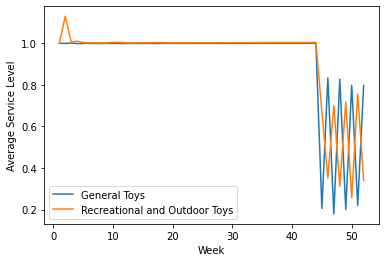

In [ ]:
plot_average_service_level(sum_stats_baseline, False, True)

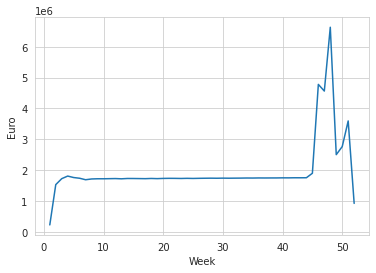

In [ ]:
plot_revenue(sum_stats_baseline, str(17), label=None)

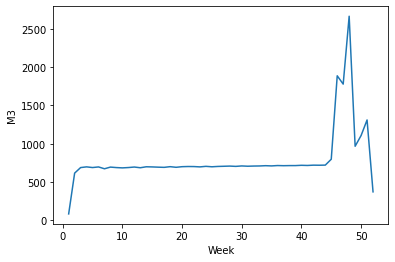

In [ ]:
plot_capacity(sum_stats_baseline)

In [ ]:
pred = pred.drop(pred[pred.week==0].index)

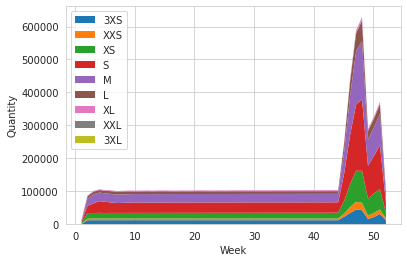

In [ ]:
sns.set_style("whitegrid")

plt.stackplot(sum_stats_baseline.index,
              pred[(pred.year==2020) & (pred.sizegroup == '3XS')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'XXS')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'XS')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'S')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'M')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'L')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'XL')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == 'XXL')].groupby('week').sum()['qtysales'],
              pred[(pred.year==2020) & (pred.sizegroup == '3XL')].groupby('week').sum()['qtysales'],
              labels = ['3XS', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL'], linewidth = 0)

plt.xlabel('Week')
plt.ylabel('Quantity')

plt.legend(loc = 'upper left')

plt.savefig('fig16.png')

plt.show()

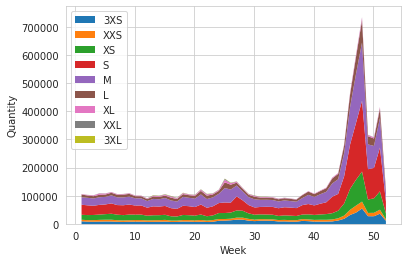

In [ ]:
year = 2019
plt.stackplot(sum_stats_baseline.index,
              pred[(pred.year==year) & (pred.sizegroup == '3XS')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'XXS')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'XS')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'S')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'M')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'L')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'XL')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == 'XXL')].groupby('week').sum()['qtysales'],
              pred[(pred.year==year) & (pred.sizegroup == '3XL')].groupby('week').sum()['qtysales'],
              labels = ['3XS', 'XXS', 'XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL'], linewidth = 0)

plt.xlabel('Week')
plt.ylabel('Quantity')

plt.legend(loc = 'upper left')

plt.savefig('fig20.png')

plt.show()

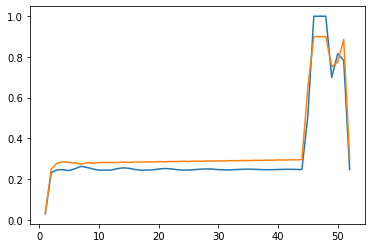

In [ ]:
plt.plot(sum_stats_baseline.index, sum_stats_baseline['Volume Small']/450)
plt.plot(sum_stats_baseline.index, sum_stats_baseline['Volume Big']/2500)
plt.show()

##Aggregated

In [ ]:
sol_agg = pd.read_excel('/content/drive/MyDrive/Seminar QML/dataFilesSolution_Aggregate_2020.xlsx', header = None)

sol_agg = sol_agg.iloc[1:].T
sol_agg = sol_agg.replace('XXXS', '3XS')
sol_agg = sol_agg.replace('XXXL', '3XL')
columns = ['Product', 'Size', 'y']
columns.extend(list(range(1, 53)))
sol_agg.columns = columns
sol_agg = sol_agg.fillna(0)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
sol_agg_z = pd.read_excel('/content/drive/MyDrive/Seminar QML/dataFilesSolution_Aggregate_2020_z.xlsx', header = None)

sol_agg_z = sol_agg_z.iloc[1:].T
sol_agg_z = sol_agg_z.replace('XXXS', '3XS')
sol_agg_z = sol_agg_z.replace('XXXL', '3XL')
columns = ['Product', 'Size', 'y']
columns.extend(list(range(1, 53)))
sol_agg_z.columns = columns
sol_agg_z = sol_agg_z.fillna(0)

/usr/local/lib/python3.7/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
weeks_agg_z, sum_stats_agg_z = sum_stats(sol_agg_z, pred[pred.year==2020])

In [ ]:
weeks_agg, sum_stats_agg = sum_stats(sol_agg, pred[pred.year==2020])

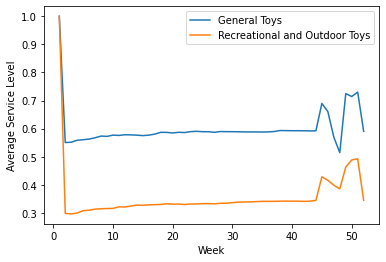

In [ ]:
plot_average_service_level(sum_stats_agg, False, True)

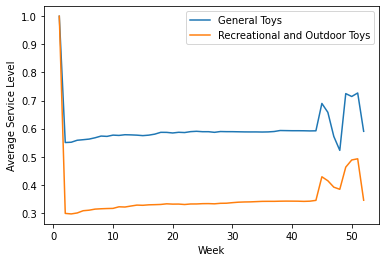

In [ ]:
plot_average_service_level(sum_stats_agg_z, False, True)

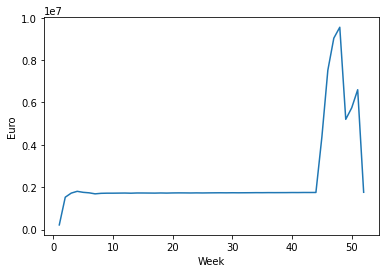

In [ ]:
plot_revenue(sum_stats_agg, str(21), label=None)

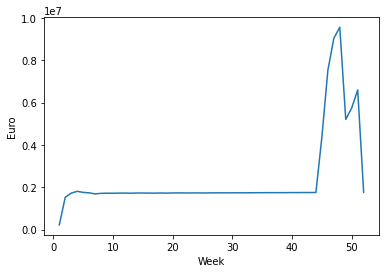

In [ ]:
plot_revenue(sum_stats_agg_z, str(24), label=None)

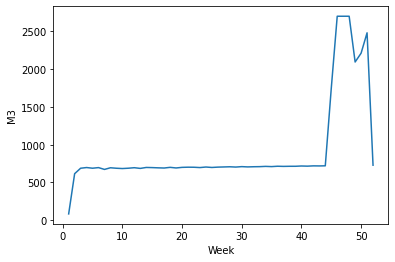

In [ ]:
plot_capacity(sum_stats_agg,str(22))

In [ ]:
sum_stats_agg.head()

,M,S,L,XS,3XS,XXS,XL,XXL,3XL,Total Revenue,Total Volume,Volume Small,Volume Big,Average Service Level (General Toys),Average Service Level (Recreational and Outdoor Toys)
1,134.0,106.0,74.0,72.0,43.0,40.0,32.0,6.0,1.0,2.209431e+05,83.959221,13.591294,70.367927,1.000000,1.000000
2,335.0,305.0,249.0,255.0,203.0,161.0,152.0,73.0,34.0,1.528540e+06,616.048154,132.757505,483.290649,0.550543,0.298298
3,335.0,305.0,249.0,255.0,203.0,161.0,152.0,73.0,34.0,1.721843e+06,688.490952,131.254307,557.236645,0.551577,0.296485
4,335.0,305.0,249.0,255.0,203.0,161.0,152.0,73.0,34.0,1.806070e+06,697.641747,131.778561,565.863186,0.558630,0.299846
5,335.0,305.0,249.0,255.0,203.0,161.0,152.0,73.0,34.0,1.758474e+06,688.852781,140.791946,548.060834,0.560611,0.307832


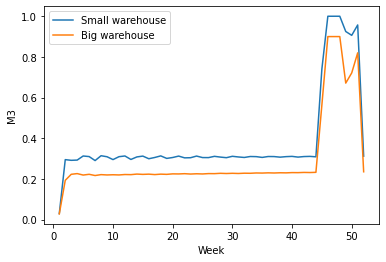

In [ ]:
plt.plot(sum_stats_agg.index, sum_stats_agg['Volume Small']/450, label='Small warehouse')
plt.plot(sum_stats_agg.index, sum_stats_agg['Volume Big']/2500, label='Big warehouse')

plt.xlabel('Week')
plt.ylabel('M3')
plt.legend()

plt.savefig('fig23.png')

plt.show()

#Trade-off 2020

In [ ]:
values = [[3639052.573952104, 2.3263, 1.96],[4183552.1066193683, 2.5758, 2.5758],[4100068.5756304944, 2.3263, 2.5758],[4047742.839108328, 2.1701, 2.5758],[4008790.2070236662, 2.0537, 2.5758],[3977285.304898761, 1.96, 2.5758],[3950710.9191027186, 1.8808, 2.5758],[3927472.2450710265, 1.8119, 2.5758],[3907033.156526464, 1.7507, 2.5758],[3888382.217801786, 1.6954, 2.5758],[3871421.708805695, 1.6449, 2.5758],[3997049.560012916, 2.5758, 2.3263],[3913414.2953436673, 2.3263, 2.3263],[3860913.217114998, 2.1701, 2.3263],[3821858.520049192, 2.0537, 2.3263],[3790295.913161559, 1.96, 2.3263],[3763442.195475595, 1.8808, 2.3263],[3739909.1821717145, 1.8119, 2.3263],[3719183.105141947, 1.7507, 2.3263],[3700248.5764640593, 1.6954, 2.3263],[3682986.1982795345, 1.6449, 2.3263],[3880316.5598550574, 2.5758, 2.1701],[3796517.351604475, 2.3263, 2.1701],[3743955.8377001383, 2.1701, 2.1701],[3704520.4443195835, 2.0537, 2.1701],[3672539.4611130026, 1.96, 2.1701],[3645530.541600688, 1.8808, 2.1701],[3621794.409775827, 1.8119, 2.1701],[3600431.5366338934, 1.7507, 2.1701],[3580583.5968171135, 1.6954, 2.1701],[3562532.159947104, 1.6449, 2.1701],[3793573.916100853, 2.5758, 2.0537],[3709664.539569664, 2.3263, 2.0537],[3656571.04219688, 2.1701, 2.0537],[3616936.868442745, 2.0537, 2.0537],[3584858.566482793, 1.96, 2.0537],[3557195.803130403, 1.8808, 2.0537],[3532452.5006023543, 1.8119, 2.0537],[3510636.2123001516, 1.7507, 2.0537],[3490722.8868148336, 1.6954, 2.0537],[3472593.003664471, 1.6449, 2.0537],[3723386.7820179453, 2.5758, 1.96],[3639052.573952104, 2.3263, 1.96],[3585738.5427846173, 2.1701, 1.96],[3546003.6951666325, 2.0537, 1.96],[3512963.7326330966, 1.96, 1.96],[3484611.695067558, 1.8808, 1.96],[3459791.5543339537, 1.8119, 1.96],[3437934.609071609, 1.7507, 1.96],[3417765.0032879226, 1.6954, 1.96],[3399238.530383443, 1.6449, 1.96],[3663937.9438503426, 2.5758, 1.8808],[3579164.1575856656, 2.3263, 1.8808],[3525764.353588227, 2.1701, 1.8808],[3485171.9030774906, 2.0537, 1.8808],[3451543.683934714, 1.96, 1.8808],[3423142.7990980647, 1.8808, 1.8808],[3398262.88226472, 1.8119, 1.8808],[3376016.3107916526, 1.7507, 1.8808],[3355517.6341325296, 1.6954, 1.8808],[3336580.9968483727, 1.6449, 1.8808],[3612312.629502504, 2.5758, 1.8119],[3527248.6628869986, 2.3263, 1.8119],[3473406.244331614, 2.1701, 1.8119],[3431980.07723221, 2.0537, 1.8119],[3398299.7608444705, 1.96, 1.8119],[3369842.723458401, 1.8808, 1.8119],[3344538.2360664303, 1.8119, 1.8119],[3321975.386864277, 1.7507, 1.8119],[3301107.3178316155, 1.6954, 1.8119],[3282080.8460766952, 1.6449, 1.8119],[3566026.7673051627, 2.5758, 1.7507],[3480828.3397777826, 2.3263, 1.7507],[3426102.467993457, 2.1701, 1.7507],[3384428.974691926, 2.0537, 1.7507],[3350705.1617592494, 1.96, 1.7507],[3321871.2028104723, 1.8808, 1.7507],[3296262.7073232336, 1.8119, 1.7507],[3273370.3597214147, 1.7507, 1.7507],[3252366.6201184983, 1.6954, 1.7507],[3233146.9465394453, 1.6449, 1.7507],[3524142.561226743, 2.5758, 1.6954],[3438691.12154913, 2.3263, 1.6954],[3383124.1782453367, 2.1701, 1.6954],[3341399.7365028053, 2.0537, 1.6954],[3307464.021395137, 1.96, 1.6954],[3278307.033202778, 1.8808, 1.6954],[3252302.5985545604, 1.8119, 1.6954],[3229263.2675418025, 1.7507, 1.6954],[3208088.5340689914, 1.6954, 1.6954],[3188841.9202342513, 1.6449, 1.6954],[3485986.257980367, 2.5758, 1.6449],[3400004.8296864643, 2.3263, 1.6449],[3343982.9460850805, 2.1701, 1.6449],[3302211.809659177, 2.0537, 1.6449],[3267873.6949491147, 1.96, 1.6449],[3238330.686457512, 1.8808, 1.6449],[3212203.996443298, 1.8119, 1.6449],[3188976.08727565, 1.7507, 1.6449],[3167783.764249445, 1.6954, 1.6449],[3148518.907663934, 1.6449, 1.6449]]

In [ ]:
tradeoff = pd.DataFrame(values)

tradeoff.head()

,0,1,2
0,3.639053e+06,2.3263,1.9600
1,4.183552e+06,2.5758,2.5758
2,4.100069e+06,2.3263,2.5758
3,4.047743e+06,2.1701,2.5758
4,4.008790e+06,2.0537,2.5758


In [ ]:
tradeoff.columns = ['Relevance Score', 'Critical Value GT', 'Critical Value ROT']

In [ ]:
tradeoff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Relevance Score     101 non-null    float64
 1   Critical Value GT   101 non-null    float64
 2   Critical Value ROT  101 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


In [ ]:
criticalValues = [2.5758, 2.3263, 2.1701, 2.0537, 1.96, 1.8808, 1.8119, 1.7507, 1.6954, 1.6449]
servicelevel = 1 - np.array(list(range(1, 11)))/100

for i in range(10):
  tradeoff[['Critical Value GT', 'Critical Value ROT']] = tradeoff[['Critical Value GT', 'Critical Value ROT']].replace(criticalValues[i], servicelevel[i])

tradeoff.head()

,Relevance Score,Critical Value GT,Critical Value ROT
0,3.639053e+06,0.98,0.95
1,4.183552e+06,0.99,0.99
2,4.100069e+06,0.98,0.99
3,4.047743e+06,0.97,0.99
4,4.008790e+06,0.96,0.99


In [ ]:
tradeoff.columns = ['Relevance Score', 'Service Level GT', 'Service Level ROT']

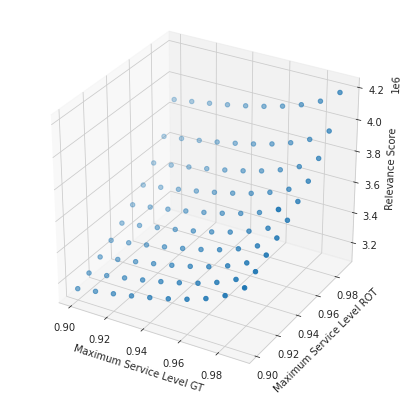

In [ ]:
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(tradeoff['Service Level GT'], tradeoff['Service Level ROT'], tradeoff['Relevance Score'])

ax.set_xlabel('Maximum Service Level GT')
ax.set_ylabel('Maximum Service Level ROT')
ax.set_zlabel('Relevance Score')

plt.savefig('fig18.png')

plt.show()

In [ ]:
general_tradeoff = tradeoff[tradeoff['Service Level GT'] == tradeoff['Service Level ROT']]

general_tradeoff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 1 to 100
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Relevance Score    10 non-null     float64
 1   Service Level GT   10 non-null     float64
 2   Service Level ROT  10 non-null     float64
dtypes: float64(3)
memory usage: 320.0 bytes


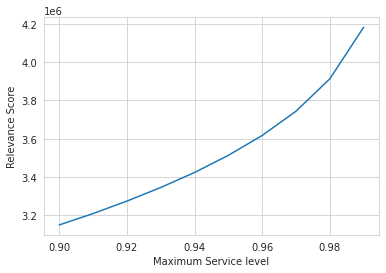

In [ ]:
plt.plot(general_tradeoff['Service Level ROT'], general_tradeoff['Relevance Score'])
plt.xlabel('Maximum Service level')
plt.ylabel('Relevance Score')
plt.savefig('fig19.png')
plt.show()